# Callback: Custom Resource

Consider again the Vehicle Routing Problem with Time Windows but let's do the `time` resource ourselves.

Hook into the dynamic programming algorithm and do initialization, extension and dominance manually.

In [1]:
# data

from flowty import (
    Model,
    xsum,
    OptimizationStatus,
    CallbackModel,
    Where,
)
from flowty.datasets import vrp_rep

# fetch data
bunch = vrp_rep.fetch_vrp_rep(
    "solomon-1987-r1", instance="R101_025"
)
name, n, es, c, d, Q, t, a, b, x, y = bunch["instance"]

In [2]:
# VRPTW

m = Model()
m.setParam("CallbackDP", "On")

# the graph
g = m.addGraph(
    obj=c, edges=es, source=0, sink=n - 1, L=1, U=n - 2, type="B"
)

# resource constriants
m.addResourceDisposable(
    graph=g, consumptionType="V", weight=d, boundsType="V", lb=0, ub=Q, name="d"
)

# m.addResourceDisposable(
#     graph=g,
#     consumptionType="E",
#     weight=t,
#     boundsType="V",
#     lb=a,
#     ub=b,
#     name="t",
# )


def callback(cb: CallbackModel, where: Where):
    # initialization
    if where == Where.DPInit:
        cb.setResource("time", 0)

    # extension
    if where == Where.DPExtend:
        e = cb.edge
        j = es[e][1]
        value = cb.getResource("time")
        value = max(a[j], value + t[e])

        if value > b[j]:
            cb.reject()
            print("Not extended")
        else:
            cb.setResource("time", value)

    # dominance
    if where == Where.DPDominate:
        value = cb.getResource("time")
        other = cb.getResourceOther("time")

        if other < value:
            cb.reject()
            print("Dominated")


m.setCallback(callback)
m.addResourceCustom(graph=g, name="time")

# set partitioning constraints
for i in range(n)[1:-1]:
    m.addConstr(xsum(1 * x for x in g.vars if i == x.source) == 1)
    
    packingSet = [x for x in g.vars if i == x.source]
    m.addPackingSet(packingSet)

status = m.optimize()

print(f"ObjectiveValue {m.objectiveValue}")

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not e

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not 

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not ext

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not e

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exte

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exten

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exte

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Domina

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exte

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not e

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominate

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
N

Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not ex

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not ex

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Do

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not e

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extende

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not e

Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
No

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exte

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Dominated
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not e

Not extended
Dominated
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Dominated
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not exte

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended
Not extended

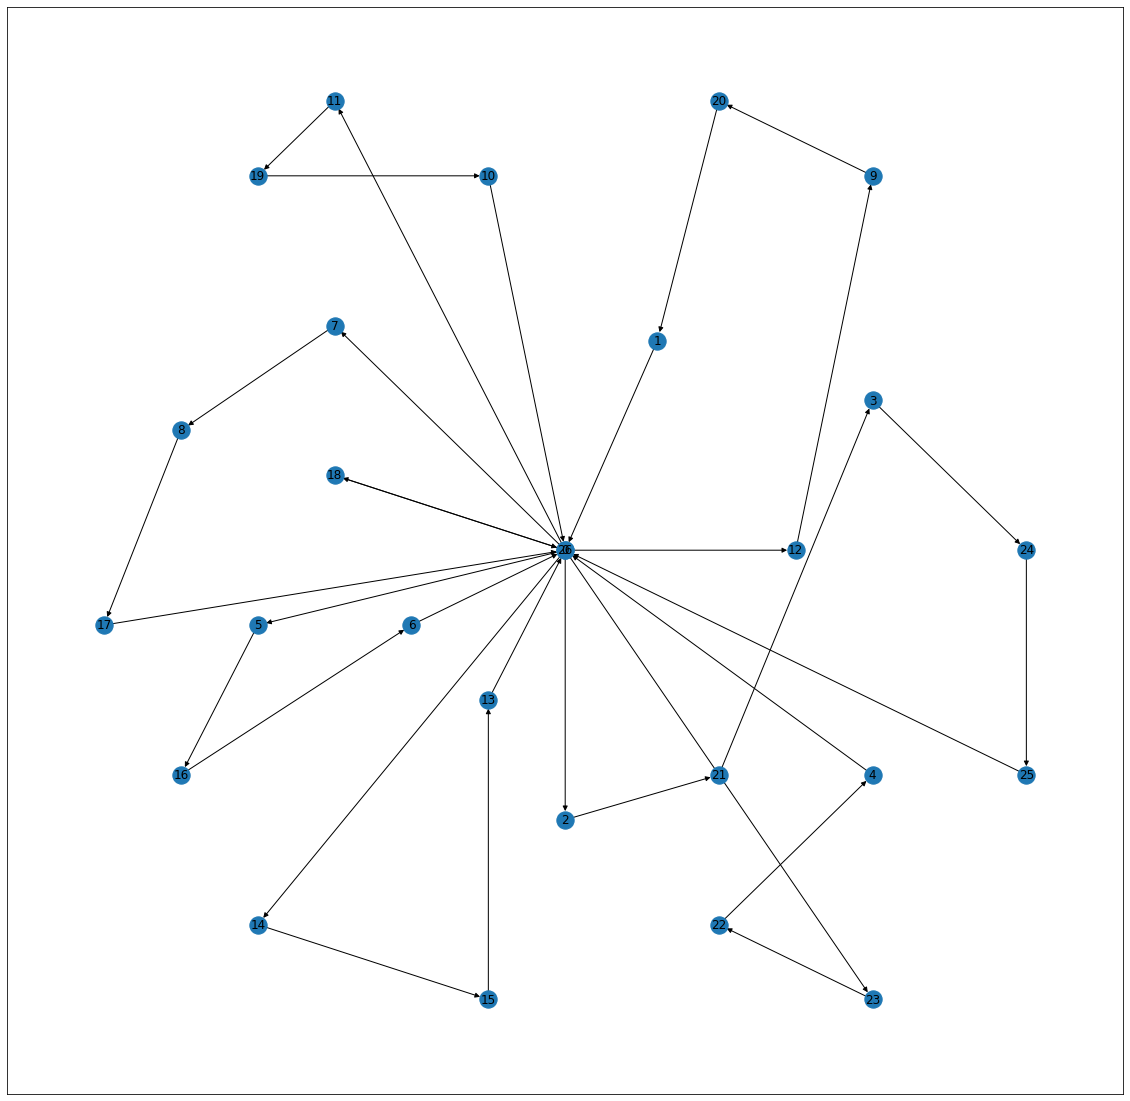

In [3]:
# display

# get the variables
xs = m.vars

# and print them
# for var in xs:
#    if var.x > 0:
#        print(f"{var.name} id:{var.idx} = {var.x}")

# display solution
import math
import networkx
import matplotlib
import matplotlib.pyplot as plt

if (
    status == OptimizationStatus.Optimal
    or status == OptimizationStatus.Feasible
):
    plt.figure(figsize=(20,20))
    edges = [
        var.edge
        for var in g.vars
        if not math.isclose(var.x, 0, abs_tol=0.001)
    ]
    g = networkx.DiGraph()
    g.add_nodes_from([i for i in range(n)])
    g.add_edges_from(edges)
    pos = {i: (x[i], y[i]) for i in range(n)}

    networkx.draw_networkx_nodes(g, pos, nodelist=g.nodes)
    labels = {i: i for i in g.nodes}
    networkx.draw_networkx_labels(g, pos, labels=labels)

    networkx.draw_networkx_edges(g, pos, nodelist=g.edges)

    plt.show()